In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bpink206/p11.txt
/kaggle/input/bpink206/p1.jpg
/kaggle/input/bpink206/p17.txt
/kaggle/input/bpink206/p7.txt
/kaggle/input/bpink206/p2.jpg
/kaggle/input/bpink206/p12.txt
/kaggle/input/bpink206/p19.txt
/kaggle/input/bpink206/p15.txt
/kaggle/input/bpink206/p8.jpg
/kaggle/input/bpink206/p5.jpg
/kaggle/input/bpink206/p17.jpg
/kaggle/input/bpink206/p16.txt
/kaggle/input/bpink206/p13.txt
/kaggle/input/bpink206/p9.jpg
/kaggle/input/bpink206/p18.jpg
/kaggle/input/bpink206/p3.jpg
/kaggle/input/bpink206/p10.txt
/kaggle/input/bpink206/p11.jpg
/kaggle/input/bpink206/p6.txt
/kaggle/input/bpink206/p10.jpg
/kaggle/input/bpink206/p9.txt
/kaggle/input/bpink206/p21.jpg
/kaggle/input/bpink206/p24.jpg
/kaggle/input/bpink206/p21.txt
/kaggle/input/bpink206/p24.txt
/kaggle/input/bpink206/p18.txt
/kaggle/input/bpink206/p8.txt
/kaggle/input/bpink206/p22.txt
/kaggle/input/bpink206/p22.jpg
/kaggle/input/bpink206/p14.txt
/kaggle/input/bpink206/p16.jpg
/kaggle/input/bpink206/p6.jpg
/kaggle/input/bpink

In [2]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2

In [3]:
import glob
imgdir = "../input/bpink206/"
img_names = sorted(glob.glob(imgdir + "*.jpg"))
label_names = sorted(glob.glob(imgdir+ "*.txt"))

In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
def read_label(labelfile):
    content = open(labelfile).readlines()
    list_with_all_boxes = []
    list_names = []
    for item in content:
        classname, xcen, ycen, w, h = item.rstrip().split()
        list_with_single_boxes = [float(xcen),float(ycen),float(w),float(h)]
        list_with_all_boxes.append(list_with_single_boxes)
        list_names.append(int(classname))
    return list_names, list_with_all_boxes

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    imgSize = np.shape(img)
    xcen, ycen, w, h = bbox
    x_min = int(max(xcen - w/2, 0)*imgSize[1])
    x_max = int(min(xcen + w/2, 1)*imgSize[1])
    y_min = int(max(ycen - h/2, 0)*imgSize[0])
    y_max = int(min(ycen + h/2, 1)*imgSize[0])
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

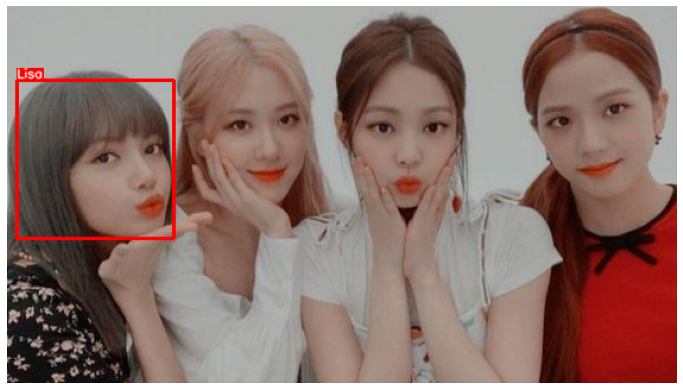

In [5]:
from PIL import Image
category_id_to_name = {0: "Lisa"}
image = np.array(Image.open(img_names[0]))
class_labels, bboxes = read_label(label_names[0])
visualize(image, bboxes, class_labels, category_id_to_name)

In [6]:
img_size = 416 #ปรับภาพ
train_transform = A.Compose([
    A.Resize(width=img_size, height=img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.25, rotate_limit=45, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.2))

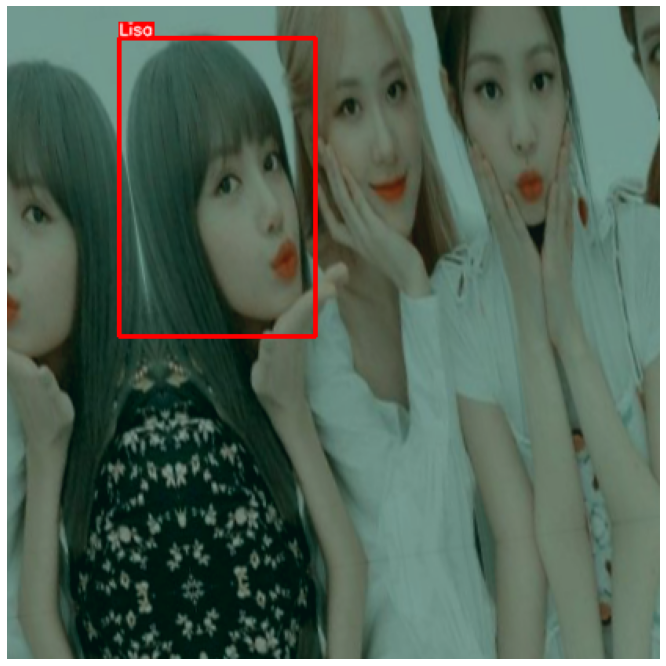

In [7]:
#ลองทดสอบดู
transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
visualize(transformed_image, transformed_bboxes, transformed_class_labels, category_id_to_name)

In [8]:
!mkdir LISA

In [9]:
outdir = "./LISA/"
for i in range(len(img_names)-5): #traning
    image = np.array(Image.open(img_names[i]))
    class_labels, bboxes = read_label(label_names[i])
    onlyname = img_names[i].split('/')[-1].split('.')[0]
    for ii in range(20):
        transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']
        transformed_name = onlyname+'_'+str(ii)
        cv2.imwrite(outdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
        out_file = open(outdir + transformed_name +'.txt', 'w')
        for iii in range(len(transformed_bboxes)):
            bIn  =  A.augmentations.bbox_utils.convert_bbox_to_albumentations(transformed_bboxes[iii], 'yolo', img_size, img_size, check_validity=True)
            bOut = A.augmentations.bbox_utils.convert_bbox_from_albumentations(bIn, 'yolo', img_size, img_size, check_validity=True)
            out_file.write(str(0) + " " + " ".join([str(b) for b in bOut]) + '\n')
        out_file.close()

In [10]:
!mkdir LISA_VAL

In [11]:
val_transform = A.Compose([
    A.Resize(width=img_size, height=img_size),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.2))

In [12]:
outdir = "./LISA_VAL/"
for i in range(7, len(img_names)):
    image = cv2.imread(img_names[i])
    class_labels, bboxes = read_label(label_names[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    onlyname = img_names[i].split('/')[-1].split('.')[0]

    transformed = val_transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']
    transformed_name = onlyname
    cv2.imwrite(outdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
    out_file = open(outdir + transformed_name +'.txt', 'w')
    for iii in range(len(transformed_bboxes)):
        bIn  =  A.augmentations.bbox_utils.convert_bbox_to_albumentations(transformed_bboxes[iii], 'yolo', img_size, img_size, check_validity=True)
        bOut = A.augmentations.bbox_utils.convert_bbox_from_albumentations(bIn, 'yolo', img_size, img_size, check_validity=True)
        out_file.write(str(0) + " " + " ".join([str(b) for b in bOut]) + '\n')
    out_file.close()

In [13]:
outdir = "./LISA_VAL/"
for i in range(5, len(img_names)-1):
    image = cv2.imread(img_names[i])
    class_labels, bboxes = read_label(label_names[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    onlyname = img_names[i].split('/')[-1].split('.')[0]

    transformed = val_transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']
    transformed_name = onlyname
    cv2.imwrite(outdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
    out_file = open(outdir + transformed_name +'.txt', 'w')
    for iii in range(len(transformed_bboxes)):
        bIn  =  A.augmentations.bbox_utils.convert_bbox_to_albumentations(transformed_bboxes[iii], 'yolo', img_size, img_size, check_validity=True)
        bOut = A.augmentations.bbox_utils.convert_bbox_from_albumentations(bIn, 'yolo', img_size, img_size, check_validity=True)
        out_file.write(str(0) + " " + " ".join([str(b) for b in bOut]) + '\n')
    out_file.close()

In [14]:
!ls ./LISA_VAL/*

./LISA_VAL/p14.jpg  ./LISA_VAL/p19.jpg	./LISA_VAL/p23.jpg  ./LISA_VAL/p5.jpg
./LISA_VAL/p14.txt  ./LISA_VAL/p19.txt	./LISA_VAL/p23.txt  ./LISA_VAL/p5.txt
./LISA_VAL/p15.jpg  ./LISA_VAL/p2.jpg	./LISA_VAL/p24.jpg  ./LISA_VAL/p6.jpg
./LISA_VAL/p15.txt  ./LISA_VAL/p2.txt	./LISA_VAL/p24.txt  ./LISA_VAL/p6.txt
./LISA_VAL/p16.jpg  ./LISA_VAL/p20.jpg	./LISA_VAL/p25.jpg  ./LISA_VAL/p7.jpg
./LISA_VAL/p16.txt  ./LISA_VAL/p20.txt	./LISA_VAL/p25.txt  ./LISA_VAL/p7.txt
./LISA_VAL/p17.jpg  ./LISA_VAL/p21.jpg	./LISA_VAL/p3.jpg   ./LISA_VAL/p8.jpg
./LISA_VAL/p17.txt  ./LISA_VAL/p21.txt	./LISA_VAL/p3.txt   ./LISA_VAL/p8.txt
./LISA_VAL/p18.jpg  ./LISA_VAL/p22.jpg	./LISA_VAL/p4.jpg   ./LISA_VAL/p9.jpg
./LISA_VAL/p18.txt  ./LISA_VAL/p22.txt	./LISA_VAL/p4.txt   ./LISA_VAL/p9.txt


In [15]:
#version use import torch, torchvision
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__, torchvision.__version__)
os.getcwd()

1.7.1+cu110 0.8.2+cu110


'/kaggle/working'

In [16]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 9143, done.
remote: Total 9143 (delta 0), reused 0 (delta 0), pack-reused 9143
Receiving objects: 100% (9143/9143), 9.76 MiB | 18.47 MiB/s, done.
Resolving deltas: 100% (6344/6344), done.


In [17]:
os.chdir("/kaggle/working/yolov5")
!pip install -r ./requirements.txt

In [18]:
os.chdir("/kaggle/working/yolov5")
import glob
filename = glob.glob('/kaggle/working/LISA/*.jpg')
filename.sort()
f = open("./train.txt", "w")
for name in filename:
    f.write(name+"\n")
f.close()

filename = glob.glob('/kaggle/working/LISA_VAL/*.jpg')
filename.sort()
f = open("./val.txt", "w")
for name in filename:
    f.write(name+"\n")
f.close()

In [19]:
os.chdir("/kaggle/working/yolov5")
f = open("./train.yaml", "w")
f.write('train: ./train.txt'+"\n")
f.write('val: ./val.txt'+"\n")
f.write('nc: 1'+"\n")
f.write('names: [ \'LISA\' ]'+"\n")#ชื่อที่จะทาย
f.close()

In [20]:
!wandb disabled

W&B disabled.


In [34]:
os.chdir("/kaggle/working/yolov5")
!python train.py --img 416 --batch 8 --epochs 100 --data train.yaml --cfg ./models/yolov5s.yaml --name LISA

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=train.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=LISA, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-09-21 08:19:00.017009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
100%|███████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 125MB/s]

train: Scanning 'train' images and labels...440 found, 0 missing, 9 empty, 0 cor
val: Scanning 'val' images and labels...19 found

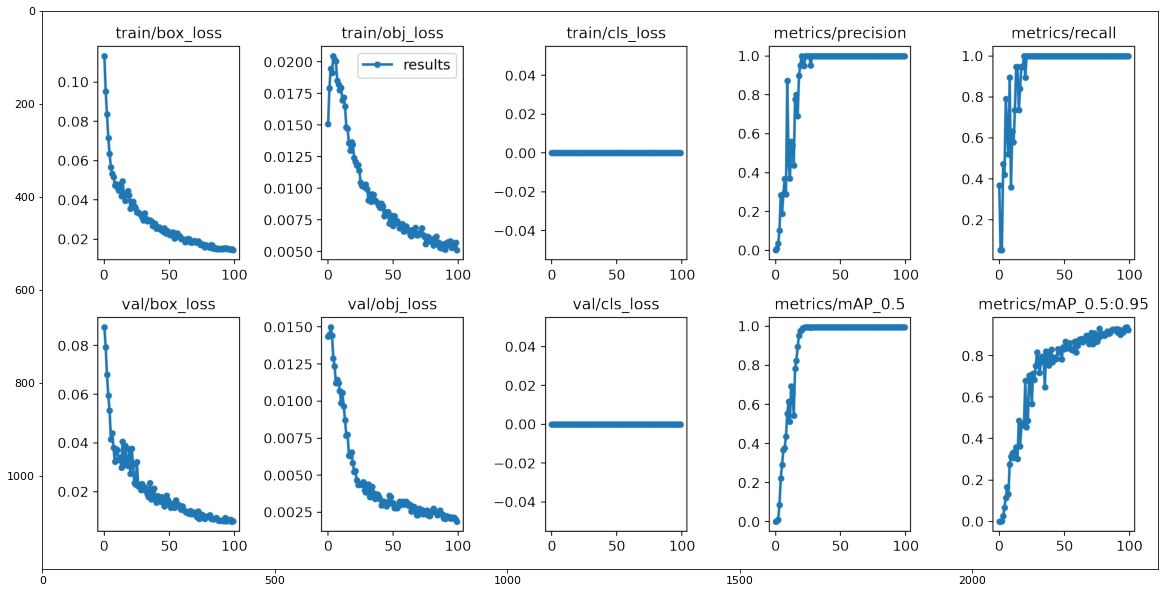

In [45]:
os.chdir("/kaggle/working/yolov5")
from utils.plots import plot_results 
plot_results('runs/train/LISA/results.csv')
image = np.array(Image.open('runs/train/LISA/results.png'))
plt.figure(figsize=(20, 20))
plt.imshow(image)

In [46]:
os.chdir("/kaggle/working/yolov5")
from models.experimental import attempt_load
from utils.torch_utils import select_device
weights = './runs/train/LISA/weights/best.pt'
device = select_device('cpu')
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
names = model.module.names if hasattr(model, 'module') else model.names  # get class names

In [52]:
os.chdir("/kaggle/working/yolov5")
from utils.datasets import LoadImages
from utils.general import check_img_size, non_max_suppression, scale_coords
from utils.plots import Annotator, colors
h = 416
w = 416
imgsz = check_img_size([h,w], s=stride) 
dataset = LoadImages('/kaggle/working/LISA_VAL/p8.jpg', img_size=imgsz, stride=stride, auto=True)

pred_results = []
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img / 255.0
    if len(img.shape) == 3:
        img = img[None]
    pred = model(img)[0]
    pred = non_max_suppression(pred, 0.1, 0.45, None, False, max_det=1000)
    bboxes = []
    labels = []
    confs = []
    for i, det in enumerate(pred):
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in reversed(det):
                labels.append(int(cls))
                confs.append(conf.item())
                xmin, ymin, xmax, ymax = xyxy
                xcen = (xmin + xmax) / 2 / w;
                ycen = (ymin + ymax) / 2 / h;
                ww = (xmax - xmin) / w;
                hh = (ymax - ymin) / h;
                bboxes.append([xcen.item(), ycen.item(), ww.item(), hh.item()])
    pred_results.append([path, bboxes, labels, confs])

image 1/1 /kaggle/working/LISA_VAL/p8.jpg: 

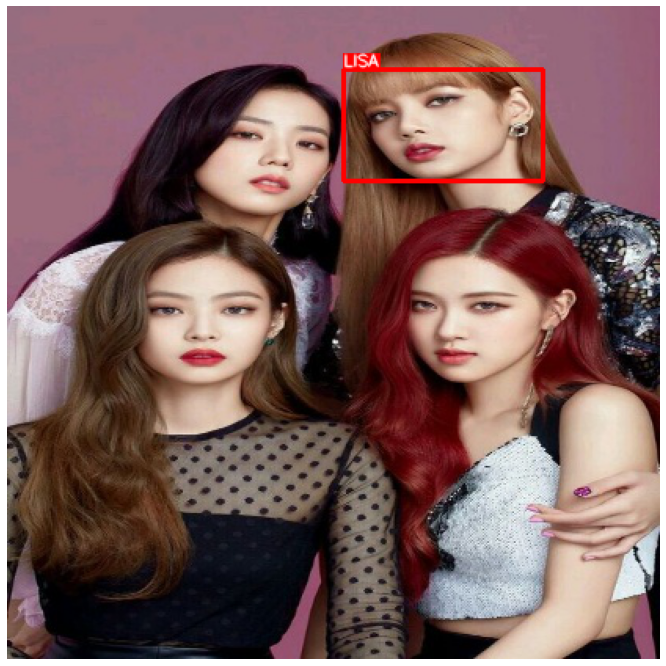

In [53]:
path, bboxes, labels, confs = pred_results[0]
image = np.array(Image.open(path))
visualize(image, bboxes, labels, names)

In [54]:
confs

[0.9061986804008484]

In [55]:
!ls /kaggle/working/LISA_VAL

p14.jpg  p16.txt  p19.jpg  p20.txt  p23.jpg  p25.txt  p5.jpg  p7.txt
p14.txt  p17.jpg  p19.txt  p21.jpg  p23.txt  p3.jpg   p5.txt  p8.jpg
p15.jpg  p17.txt  p2.jpg   p21.txt  p24.jpg  p3.txt   p6.jpg  p8.txt
p15.txt  p18.jpg  p2.txt   p22.jpg  p24.txt  p4.jpg   p6.txt
p16.jpg  p18.txt  p20.jpg  p22.txt  p25.jpg  p4.txt   p7.jpg
